Example on how to implement, train and use a Conditional VAE using the mnist dataset.

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import logging
import random
from sklearn.manifold import TSNE

tf.get_logger().setLevel(logging.ERROR)

# Load data

In [2]:
# Load traditional MNIST dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Scale the data.
train_images = train_images / 255.0
test_images = test_images / 255.0



# VAE

In [3]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    Uses the Reparametrization Trick."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [4]:
latent_dim = 50

encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1), name="input_image")
type_digit = tf.keras.layers.Input(shape=(1, ), name="encoding_input_type")

embedding_encoding = tf.keras.layers.Embedding(input_dim=10, output_dim=5)

emb_digit_type = embedding_encoding(type_digit)
emb_digit_type = tf.keras.layers.Flatten()(emb_digit_type)

x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Flatten(name="flatten_encoding")(x)
x = tf.keras.layers.Concatenate()([emb_digit_type, x])
x = tf.keras.layers.Dense(16, activation="relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model([encoder_inputs, type_digit], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoding_input_type (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_image[0][0]']            
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         50          ['encoding_input_type[0][0]

2022-08-16 00:23:43.415951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-16 00:23:43.492832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-16 00:23:43.493606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-16 00:23:43.494539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

## Decoder

In [5]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="decoding_latent_input")
type_digit = tf.keras.layers.Input(shape=(1, ), name="decoding_input_type")

emb_digit_type = tf.keras.layers.Embedding(input_dim=10, output_dim=5, name="embedding_decoder")(type_digit)
emb_digit_type = tf.keras.layers.Flatten()(emb_digit_type)

x = tf.keras.layers.Concatenate(name="concatenate_decoder")([emb_digit_type, latent_inputs])

x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(x)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model([latent_inputs, type_digit], decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoding_input_type (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 embedding_decoder (Embedding)  (None, 1, 5)         50          ['decoding_input_type[0][0]']    
                                                                                                  
 flatten_1 (Flatten)            (None, 5)            0           ['embedding_decoder[0][0]']      
                                                                                                  
 decoding_latent_input (InputLa  [(None, 50)]        0           []                         

# Variational autoencoder

In [6]:
from conditinoalvae import ConditionalVAE

In [7]:
vae_model = ConditionalVAE(encoder, decoder, recons_loss_factor=10_000, name="vae")
vae_model.compile("adam")

In [8]:
train_data = (np.expand_dims(train_images, -1), np.expand_dims(train_labels, -1))
history = vae_model.fit(train_data, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/30


2022-08-16 00:23:48.611052: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


3000/3000 [==============================] - 59s 18ms/step - loss: 486.7890 - reconstruction_loss: 0.0303 - kl_loss: 39.3793 - val_loss: 242.1154 - val_reconstruction_loss: 0.0200 - val_kl_loss: 42.5984
Epoch 2/30
3000/3000 [==============================] - 50s 17ms/step - loss: 231.5259 - reconstruction_loss: 0.0183 - kl_loss: 40.4740 - val_loss: 210.9444 - val_reconstruction_loss: 0.0174 - val_kl_loss: 37.3301
Epoch 3/30
3000/3000 [==============================] - 50s 17ms/step - loss: 205.4634 - reconstruction_loss: 0.0166 - kl_loss: 36.5689 - val_loss: 198.6023 - val_reconstruction_loss: 0.0164 - val_kl_loss: 34.2047
Epoch 4/30
3000/3000 [==============================] - 50s 17ms/step - loss: 192.3672 - reconstruction_loss: 0.0156 - kl_loss: 33.7662 - val_loss: 189.1926 - val_reconstruction_loss: 0.0156 - val_kl_loss: 32.6961
Epoch 5/30
3000/3000 [==============================] - 49s 16ms/step - loss: 182.2593 - reconstruction_loss: 0.0150 - kl_loss: 31.6276 - val_loss: 179.542

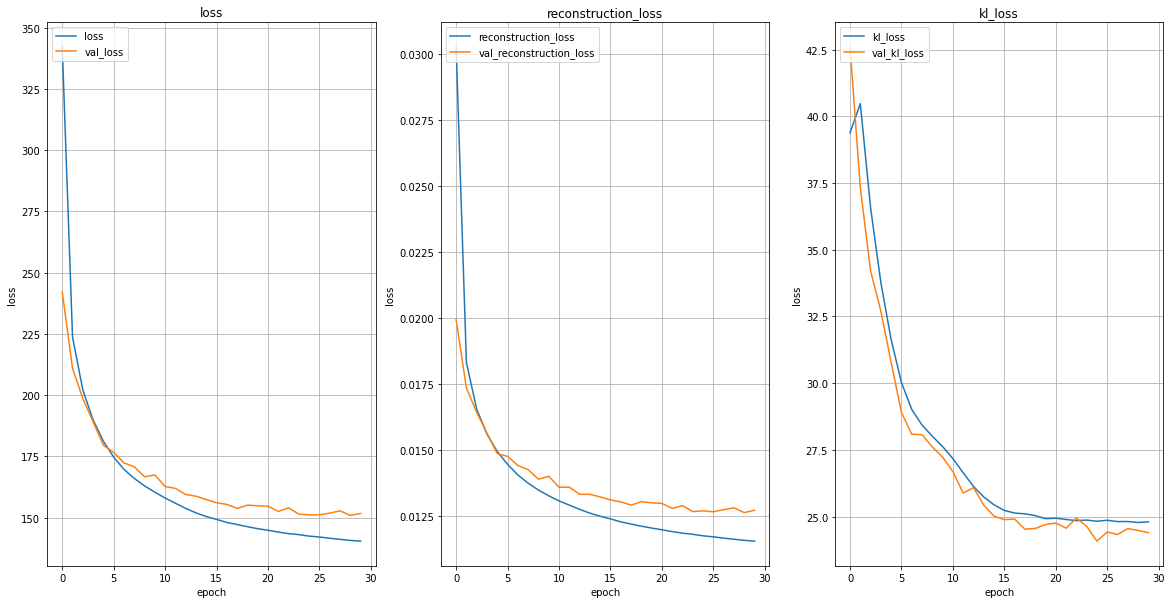

In [15]:
metrics_to_plot = [m for m in history.history.keys() if "val_" not in m]

fig, axs = plt.subplots(1, len(metrics_to_plot), figsize=(20, 10))
for m, ax in zip(metrics_to_plot, axs.flatten()):
    ax.plot(history.history[m], label=m)
    ax.plot(history.history["val_" + m], label="val_" + m)
    
    ax.set_title(m)
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(loc='upper left')
    ax.grid()

# Reconstrucción

In [21]:
N = 50
indices = range(N)
input_data = (np.expand_dims(test_images[indices, :, :], -1), np.expand_dims(test_labels[indices], -1))

test_predictions = vae_model.predict([input_data], batch_size=1)[0].squeeze()
errors = np.mean(np.abs(test_images[indices, :, :] - test_predictions), (1, 2))
indices_ordered_by_error = sorted(enumerate(errors), key=lambda x: x[1], reverse=True)

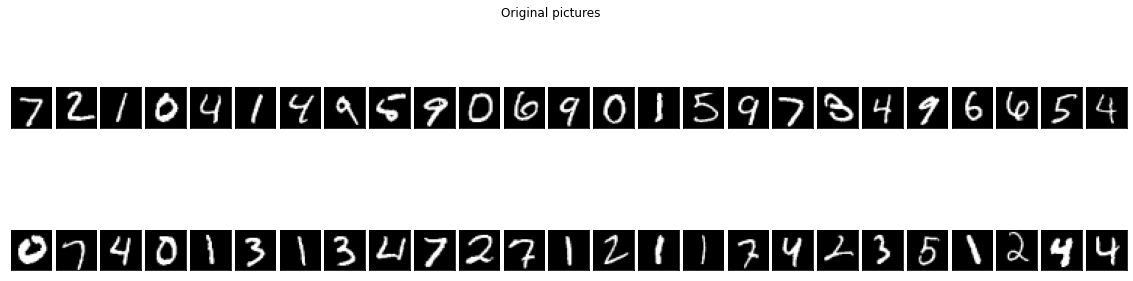

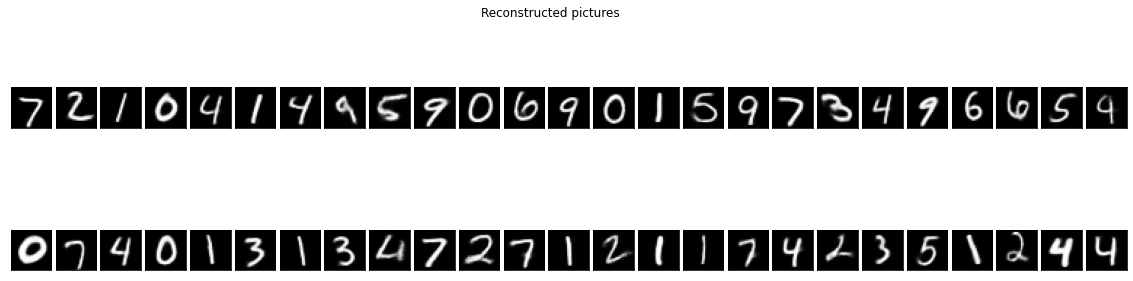

In [23]:

fig, axs = plt.subplots(2, N // 2, figsize=(20, 5), 
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for sample, ax in zip(test_images, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Original pictures")

fig, axs = plt.subplots(2, N // 2, figsize=(20, 5), 
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for sample, ax in zip(test_predictions, axs.flatten()):
    ax.imshow(sample, cmap=plt.get_cmap('gray'))
plt.suptitle("Reconstructed pictures");

# Generative model

1. We take a sample from a multinormal distribution
2. We pass it to the decoder ten times, one with each one of the possible types of digits

In [24]:
latent_rep = np.random.normal(size=latent_dim)
latent_rep = np.stack([latent_rep for _ in range(10)], axis=0)
types = np.arange(10)

In [25]:
generations = decoder.predict([latent_rep, types])

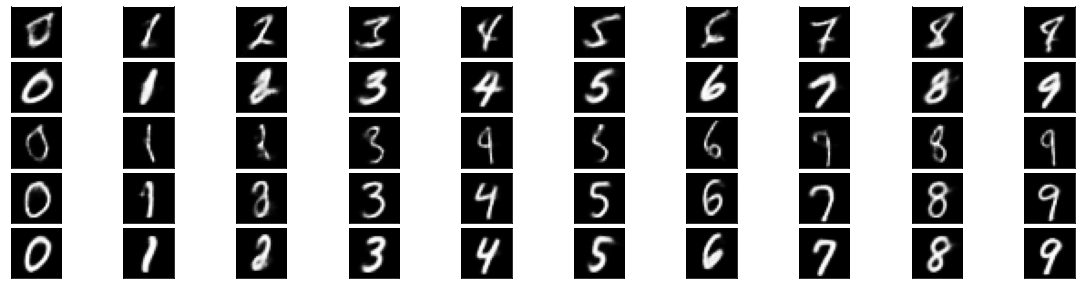

In [26]:
N = 5

fig, axs = plt.subplots(N, 10, figsize=(20, 5), 
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

types = np.arange(10)
    
for i in range(N):
    latent_rep = np.random.normal(size=latent_dim)
    latent_rep = np.stack([latent_rep for _ in range(10)], axis=0)


    generations = decoder.predict([latent_rep, types])


    for sample, ax in zip(generations, axs[i, :].flatten()):
        ax.imshow(sample, cmap=plt.get_cmap('gray'))

We appreciate:
- The right digit was generated
- Digits generated from the same sample have the same style.